In [1]:
# Importing Libraries

# pip install pandas-datareader
from pandas_datareader import data as web
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
# pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cotacao_bovespa = web.DataReader('^BVSP', data_source='yahoo', start='12-01-2009', end='12-01-2022')
modified = cotacao_bovespa.reset_index()
modified['Date']
#cotacao_bovespa

0      2009-12-01
1      2009-12-02
2      2009-12-03
3      2009-12-04
4      2009-12-07
          ...    
3066   2022-04-29
3067   2022-05-02
3068   2022-05-03
3069   2022-05-04
3070   2022-05-05
Name: Date, Length: 3071, dtype: datetime64[ns]

In [3]:
modified.dtypes

Date         datetime64[ns]
High                float64
Low                 float64
Open                float64
Close               float64
Volume              float64
Adj Close           float64
dtype: object

In [4]:
modified['mm5d'] = modified['Close'].rolling(5).mean()
modified['mm21d'] = modified['Close'].rolling(21).mean()


In [5]:
cotacao_bovespa

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-01,68616.0000,67051.00000,67051.0000,68546.000000,2326400.0,68546.000000
2009-12-02,69139.0000,68412.00000,68412.0000,68615.000000,1362000.0,68615.000000
2009-12-03,69336.0000,68308.00000,68622.0000,68315.000000,1223400.0,68315.000000
2009-12-04,69361.0000,67328.00000,68316.0000,67604.000000,1410600.0,67604.000000
2009-12-07,68866.0000,67611.00000,67611.0000,68512.000000,1186200.0,68512.000000
...,...,...,...,...,...,...
2022-04-29,111819.0000,107876.00000,109922.0000,107876.000000,13662200.0,107876.000000
2022-05-02,107884.0000,105218.00000,107876.0000,106639.000000,11935100.0,106639.000000
2022-05-03,107127.0000,106033.00000,106640.0000,106528.000000,9935500.0,106528.000000


In [6]:
modified['Close'] = modified['Close'].shift(-1)

In [7]:
modified.dropna(inplace=True)

In [8]:
qtd_linhas = len(modified)
qtd_linhas_treino = round(qtd_linhas*0.7)
qtd_linhas_teste = round(qtd_linhas*0.27)

qtd_linhas_validacao = qtd_linhas - (qtd_linhas_treino + qtd_linhas_teste)

# Mostrando as quantidades de linhas

print(qtd_linhas)
print(qtd_linhas_treino)
print(qtd_linhas_teste)

print(qtd_linhas_validacao)


3050
2135
824
91


In [9]:
#cotacao_bovespa = cotacao_bovespa.reset_index(drop=True)

In [10]:
#cotacao_bovespa.dtypes
modified['Date']

20     2010-01-04
21     2010-01-05
22     2010-01-06
23     2010-01-07
24     2010-01-08
          ...    
3065   2022-04-28
3066   2022-04-29
3067   2022-05-02
3068   2022-05-03
3069   2022-05-04
Name: Date, Length: 3050, dtype: datetime64[ns]

In [11]:
#Separando as features e labels
features = modified.drop(['Close', 'Volume', 'Adj Close', 'Date'], 1)
labels = modified['Close']



C:\Users\paula\AppData\Local\Temp\ipykernel_14216\249702833.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features = modified.drop(['Close', 'Volume', 'Adj Close', 'Date'], 1)


In [12]:
# Escolhendo as melhores features
features_list = ('Open', 'Adj Close', 'Volume', 'mm5d', 'mm21d')

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x:x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()

print ('')
print ('Melhores features: ')
print (k_best_features_final)


Melhores features: 
{'Volume': 568.3495821764052, 'Adj Close': 567.7914898775999, 'mm5d': 348.71474277998976, 'mm21d': 318.91380161979157}


In [13]:
# Normalizando as features

scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print('features: ', features_scale.shape)
print(features_scale)

features:  (3050, 5)
[[0.34403547 0.34105753 0.33327258 0.33239049 0.32396438]
 [0.34955291 0.35555796 0.3489145  0.338132   0.32486149]
 [0.35322406 0.35650952 0.35096221 0.3442547  0.32598102]
 ...
 [0.74982557 0.73715398 0.75448941 0.76463046 0.8428571 ]
 [0.74169967 0.7459667  0.74123827 0.7609811  0.83572314]
 [0.75517127 0.73407223 0.74004824 0.75880448 0.82871894]]


In [14]:
X_train = features_scale[0:qtd_linhas_treino]
X_test = features_scale[qtd_linhas_treino: qtd_linhas_treino + qtd_linhas_teste]

y_train = labels[:qtd_linhas_treino]
y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste]

print( len(X_train), len(y_train))
print( len(X_test), len(y_test))


2135 2135
824 824


In [15]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
cd = r2_score(y_test, pred)

f'Coeficiente de determinção: {cd * 100:.2f}'

'Coeficiente de determinção: 98.39'

In [16]:
# Executando a Previsão

previsao=features_scale[qtd_linhas_teste:qtd_linhas]

date_full=modified['Date']
date=date_full[qtd_linhas_teste:qtd_linhas]

res_full=modified['Close']
res=res_full[qtd_linhas_teste:qtd_linhas]

pred=lr.predict(previsao)

df=pd.DataFrame({'Date': date, 'Real': res, 'Previsão': pred})
df['Real'] = df['Real'].shift(-1)

df.set_index('Date', inplace=True)

In [18]:
df

,Real,Previsão
Date,,
2013-05-07,55448.000000,56101.920974
2013-05-08,55108.000000,56285.866157
2013-05-09,54448.000000,55348.478762
2013-05-10,54667.000000,55036.647629
2013-05-13,54936.000000,54634.028433
...,...,...
2022-04-28,106639.000000,109866.667678
2022-04-29,106528.000000,109497.221604
2022-05-02,108344.000000,105702.763410


In [17]:
modified

,Date,High,Low,Open,Close,Volume,Adj Close,mm5d,mm21d
20,2010-01-04,70081.0,68587.0,68587.0,70240.000000,1655400.0,70045.0,68484.0,68201.666667
21,2010-01-05,70595.0,69928.0,70046.0,70729.000000,1984200.0,70240.0,69014.2,68282.333333
22,2010-01-06,70937.0,70016.0,70237.0,70451.000000,2243600.0,70729.0,69579.6,68383.000000
23,2010-01-07,70723.0,70045.0,70723.0,70263.000000,1555000.0,70451.0,70010.6,68484.714286
24,2010-01-08,70766.0,70158.0,70455.0,70433.000000,1634400.0,70263.0,70345.6,68611.333333
...,...,...,...,...,...,...,...,...,...
3065,2022-04-28,110702.0,108905.0,109349.0,107876.000000,11129900.0,109919.0,109848.8,116086.476190
3066,2022-04-29,111819.0,107876.0,109922.0,106639.000000,13662200.0,107876.0,109208.4,115508.476190
3067,2022-05-02,107884.0,105218.0,107876.0,106528.000000,11935100.0,106639.0,108399.2,114859.857143
3068,2022-05-03,107127.0,106033.0,106640.0,108344.000000,9935500.0,106528.0,108062.2,114218.380952


Text(0, 0.5, 'Preço de Fechamento')

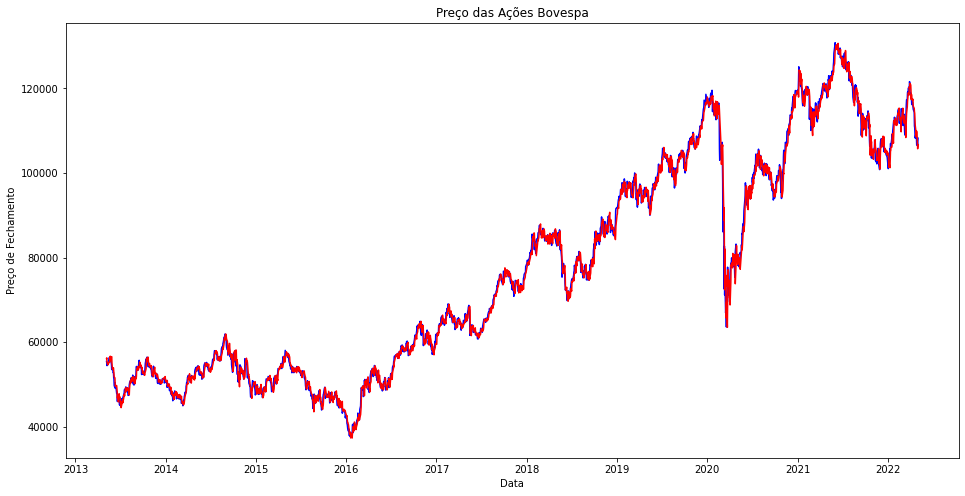

In [22]:
#grafico
plt.figure(figsize=(16,8))
plt.title('Preço das Ações Bovespa')
plt.plot(df['Real'], label="real", color='blue')
plt.plot(df['Previsão'], label="previsao", color='red')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
